In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
def create_pairs(x, digit_indices):

    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


In [ ]:
def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [ ]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()


In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.0
test_images = test_images / 255.0
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

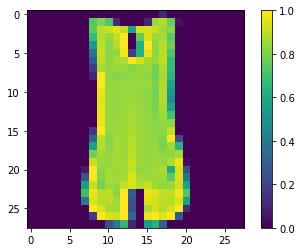

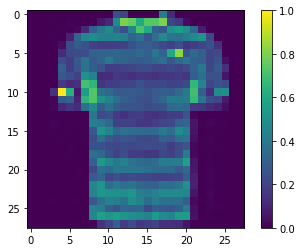

0.0


In [ ]:
i=5

show_image(tr_pairs[i][0])
show_image(ts_pairs[i][0])
print(tr_y[i])

In [ ]:
def base_network():
  input = Input(shape=(28,28,), name='base_input')
  x = Flatten(name='Flatten_input')(input)
  x = Dense(128, activation='relu', name = 'f1')(x)
  x = Dropout(0.1, name = 'D1')(x)
  x = Dense(128, activation='relu', name = 'f2')(x)
  x = Dropout(0.1, name = 'D2')(x)
  x = Dense(128, activation='relu', name = 'f3')(x)

  return Model(inputs = input, outputs =  x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidian_distance_shape(shapes):
  s1, s2 = shapes
  return (s1[0], 1)

In [ ]:
base_network = base_network()

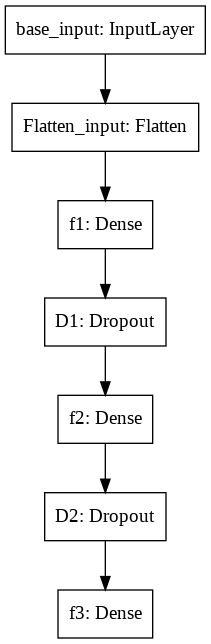

In [ ]:
plot_model(base_network, show_layer_names=True)

*italicized text*

In [ ]:
input1 = Input(shape=(28, 28,), name = "i1")
v1 = base_network(input1)

input2 = Input(shape = (28, 28, ), name = 'i2')
v2 = base_network(input2)

output = Lambda(euclidean_distance, name = 'output_layer', output_shape = euclidian_distance_shape)([v1, v2])

model = Model(inputs = [input1, input2], outputs = output)

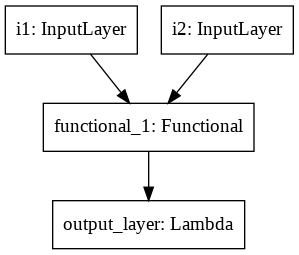

In [ ]:
plot_model(model, show_layer_names=True)

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
rms = RMSprop()
model.compile(loss = contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 10ms/step - loss: 0.1137 - val_loss: 0.0849
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0813 - val_loss: 0.0739
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0721 - val_loss: 0.0727
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0673 - val_loss: 0.0669
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0641 - val_loss: 0.0685
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0621 - val_loss: 0.0664
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0609 - val_loss: 0.0647
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0592 - val_loss: 0.0642
Epoch 9/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0581 - val_loss: 0.0677
Epoch 10/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0573 - val_loss: 0.064

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0657
Loss = 0.0656726136803627, Train Accuracy = 0.06433572262043674 Test Accuracy = 0.0916916916916917
